In [1]:
import os
# change to folder in drive
os.chdir('/content/drive/MyDrive/Colab Notebooks/New folder')

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import importlib
import planar_utils
importlib.reload(planar_utils)
from planar_utils import plot_decision_boundary, sigmoid, load_planar_dataset
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

import warnings
warnings.filterwarnings('ignore')

## Load Dataset

In [3]:
X, Y = load_planar_dataset()
print ('The shape of X is: ' + str(X.shape))
print ('The shape of Y is: ' + str(Y.shape))
print ('I have m = %d training examples!' % (Y.shape[1]))

The shape of X is: (2, 400)
The shape of Y is: (1, 400)
I have m = 400 training examples!


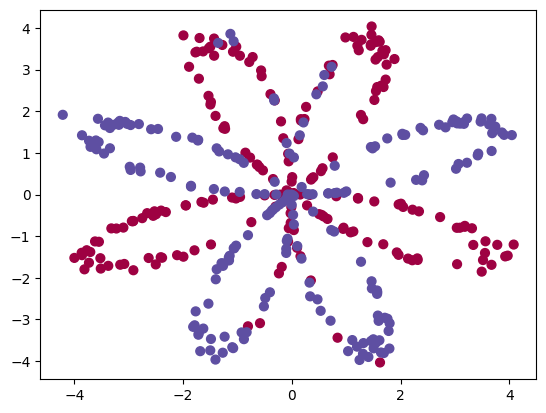

In [4]:
plt.scatter(X[0, :], X[1, :], c=Y, s=40, cmap=plt.cm.Spectral)
plt.show()

## Logistic Regression  
Before building a full neural network, let's check how logistic regression performs on this problem

Accuracy: 47.0 %


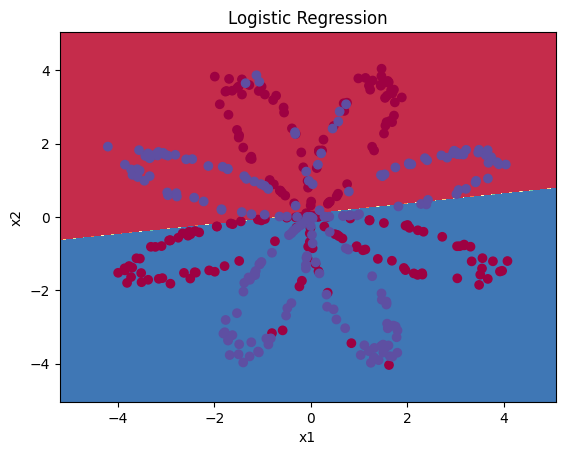

In [5]:
lr = LogisticRegression()
lr.fit(X.T, Y.T)
plot_decision_boundary(lambda x: lr.predict(x), X, Y)
plt.title("Logistic Regression")

# Accuracy
LR_predictions = lr.predict(X.T)
acc = accuracy_score(Y.T, LR_predictions) * 100
print ("Accuracy: " + str(acc) + " %")

In [6]:
def layer_sizes(X, Y, n_h=4):
    """
    Arguments:
    X -- input dataset of shape (input size(n_x), number of examples)
    Y -- labels of shape (output size(n_h), number of examples)

    Returns:
    n_x -- the size of the input layer
    n_h -- the size of the hidden layer
    n_y -- the size of the output layer
    """
    n_x = X.shape[0]
    n_h = n_h
    n_y = Y.shape[0]

    return (n_x, n_h, n_y)

In [7]:
def initialize_parameters(n_x, n_h, n_y):
    W1 = np.random.randn(n_h, n_x) * 0.01
    b1 = np.zeros((n_h, 1))
    W2 = np.random.randn(n_y, n_h) * 0.01
    b2 = np.zeros((n_y, 1))

    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2}

    return parameters

## Neural Network Model
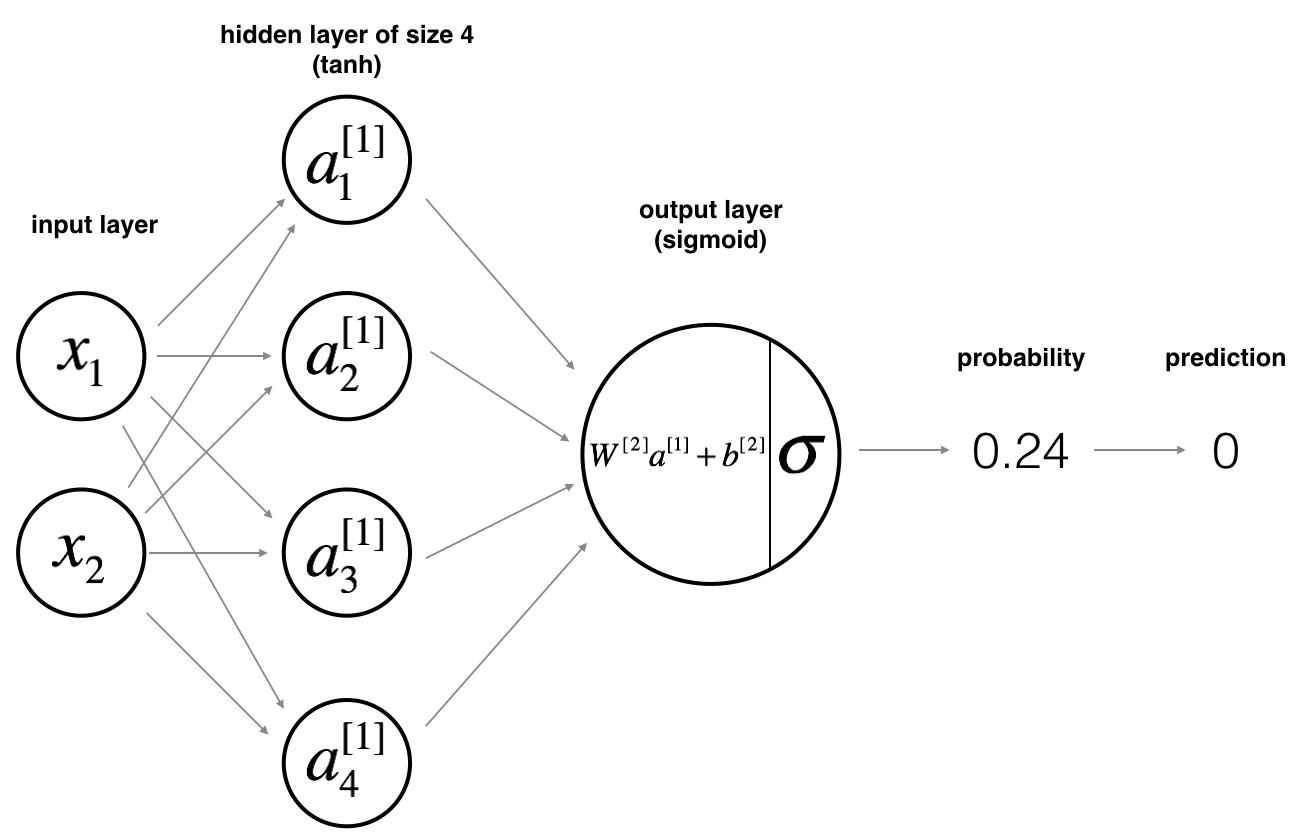

## **Mathematically (Forward Propagation)**:

For one example $x^{(i)}$:
$$z^{[1] (i)} =  W^{[1]} x^{(i)} + b^{[1]}\tag{1}$$
$$a^{[1] (i)} = \tanh(z^{[1] (i)})\tag{2}$$
$$z^{[2] (i)} = W^{[2]} a^{[1] (i)} + b^{[2]}\tag{3}$$
$$\hat{y}^{(i)} = a^{[2] (i)} = \sigma(z^{ [2] (i)})\tag{4}$$
$$y^{(i)}_{prediction} = \begin{cases} 1 & \mbox{if } a^{[2](i)} > 0.5 \\ 0 & \mbox{otherwise } \end{cases}\tag{5}$$

Given the predictions on all the examples, we can also compute the cost $J$ as follows:
$$J = - \frac{1}{m} \sum\limits_{i = 0}^{m} \large\left(\small y^{(i)}\log\left(a^{[2] (i)}\right) + (1-y^{(i)})\log\left(1- a^{[2] (i)}\right)  \large  \right) \small \tag{6}$$

### Vectorized Forward Propagation (for All Examples)

Instead of computing layer activations one example at a time, we can use matrix operations to compute the results for all \( m \) training examples at once — this is faster and more scalable.


Then, the vectorized forward propagation is:

#### Hidden Layer:

$$
Z^{[1]} = W^{[1]} X + b^{[1]}
$$


$$
A^{[1]} = \tanh(Z^{[1]})
$$



#### Output Layer:

$$
Z^{[2]} = W^{[2]} A^{[1]} + b^{[2]}
$$

$$
A^{[2]} = \sigma(Z^{[2]})
$$

Final prediction probabilities

$$
\hat{Y} = \begin{cases}
1 & \text{if } A^{[2]} > 0.5 \\
0 & \text{otherwise}
\end{cases}
$$

In [8]:
def forward_propagation(X, parameters):
    """
    Argument:
    X -- input data of size (n_x, m)
    parameters -- python dictionary containing parameters

    Returns:
    A2 -- The sigmoid output of the second activation
    cache -- a dictionary containing "Z1", "A1", "Z2" and "A2"
    """
    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']

    Z1 = np.dot(W1, X) + b1
    A1 = np.tanh(Z1)
    Z2 = np.dot(W2, A1) + b2
    A2 = sigmoid(Z2)

    cache = {"Z1": Z1,
             "A1": A1,
             "Z2": Z2,
             "A2": A2}

    return A2, cache

In [9]:
def compute_cost(A2, Y):
    m = Y.shape[1] # number of examples
    logprobs = np.multiply(np.log(A2), Y) + np.multiply(np.log(1 - A2),1 - Y)
    cost = -np.sum(logprobs)/m

    cost = float(np.squeeze(cost))  # E.g., turns [[17]] into 17
    return cost

In [10]:
def backward_propagation(parameters, cache, X, Y):
    """
    Implement the backward propagation

    Arguments:
    parameters -- python dictionary containing our parameters
    cache -- a dictionary containing "Z1", "A1", "Z2" and "A2".
    X -- input data of shape (2, number of examples)
    Y -- "true" labels vector of shape (1, number of examples)

    Returns:

    grads -- python dictionary containing gradients with respect to different parameters
    """
    m = X.shape[1]

    W1 = parameters['W1']
    W2 = parameters['W2']

    A1 = cache['A1']
    A2 = cache['A2']

    dZ2 = A2 - Y
    dW2 = (1/m) * np.dot(dZ2, A1.T)
    db2 = (1/m) * np.sum(dZ2, axis=1, keepdims=True)
    dZ1 = np.dot(W2.T,dZ2) * (1 - A1**2)
    dW1 = (1/m) * np.dot(dZ1, X.T)
    db1 = (1/m) * np.sum(dZ1, axis=1, keepdims=True)

    grads = {"dW1": dW1,
             "db1": db1,
             "dW2": dW2,
             "db2": db2}

    return grads

In [11]:
def update_parameters(parameters, grads, learning_rate = 1.2):
    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']

    dW1 = grads['dW1']
    db1 = grads['db1']
    dW2 = grads['dW2']
    db2 = grads['db2']

    W1 = W1 - learning_rate*dW1
    b1 = b1 - learning_rate*db1
    W2 = W2 - learning_rate*dW2
    b2 = b2 - learning_rate*db2

    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2}

    return parameters

In [12]:
def nn_model(X, Y, n_h, num_iterations=10000, learning_rate=0.01, print_cost=False):
    """
    Implements a two-layer neural network: LINEAR -> TANH -> LINEAR -> SIGMOID

    Arguments:
    X -- input data of shape (n_x, m)
    Y -- labels vector of shape (1, m)
    n_h -- number of neurons in the hidden layer
    num_iterations -- number of iterations for gradient descent
    print_cost -- if True, prints the cost every 1000 iterations

    Returns:
    parameters -- learned model parameters
    """

    np.random.seed(3)

    # Get layer sizes
    n_x, n_h, n_y = layer_sizes(X, Y, n_h)

    # Step 1: Initialize parameters
    parameters = initialize_parameters(n_x, n_h, n_y)

    # Step 2: Gradient descent loop
    cost_history = []
    for i in range(num_iterations):

        # Forward propagation
        A2, cache = forward_propagation(X, parameters)

        # Compute cost
        cost = compute_cost(A2, Y)

        # Backward propagation
        grads = backward_propagation(parameters, cache, X, Y)

        # Update parameters using gradient descent
        parameters = update_parameters(parameters, grads, learning_rate)

        # Print cost every 500 iterations
        if print_cost and i % 1000 == 0:
            print(f"Cost after iteration {i}: {cost:.6f}")
            cost_history.append(cost)

    return parameters, cost_history

In [13]:
def predict(parameters, X):
    A2, cache = forward_propagation(X, parameters)
    predictions = (A2 > 0.5).astype(int)
    return predictions

Learning Rate: 0.01
Cost after iteration 0: 0.693162
Cost after iteration 1000: 0.691906
Cost after iteration 2000: 0.680653
Cost after iteration 3000: 0.675728
Cost after iteration 4000: 0.669382
Cost after iteration 5000: 0.647742
Cost after iteration 6000: 0.629994
Cost after iteration 7000: 0.622308
Cost after iteration 8000: 0.618561
Cost after iteration 9000: 0.615939
--------------------------------------------------
Learning Rate: 0.05
Cost after iteration 0: 0.693162
Cost after iteration 1000: 0.647979
Cost after iteration 2000: 0.613646
Cost after iteration 3000: 0.602915
Cost after iteration 4000: 0.595874
Cost after iteration 5000: 0.591110
Cost after iteration 6000: 0.586356
Cost after iteration 7000: 0.577753
Cost after iteration 8000: 0.565631
Cost after iteration 9000: 0.556369
--------------------------------------------------
Learning Rate: 0.1
Cost after iteration 0: 0.693162
Cost after iteration 1000: 0.613686
Cost after iteration 2000: 0.595912
Cost after iteration

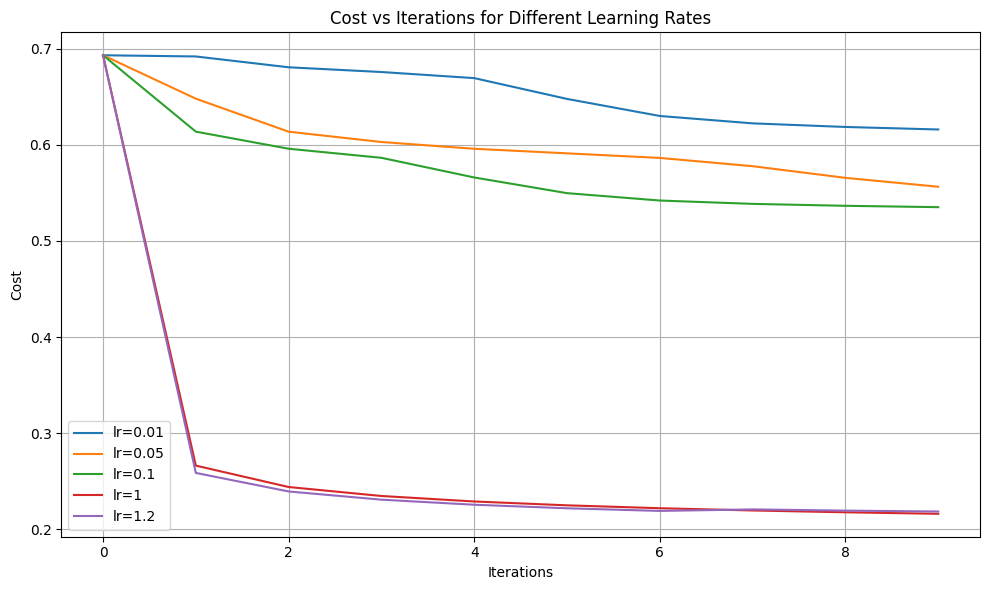

In [14]:
learning_rates = [0.01, 0.05, 0.1, 1, 1.2]

plt.figure(figsize=(10, 6))

for rate in learning_rates:
    print("Learning Rate:", rate)
    parameters, cost_history = nn_model(X, Y, n_h=4, num_iterations=10000, learning_rate=rate, print_cost=True)
    print('-'*50)
    plt.plot(np.squeeze(cost_history), label=f"lr={rate}")

plt.ylabel('Cost')
plt.xlabel('Iterations')
plt.title('Cost vs Iterations for Different Learning Rates')
plt.legend()  # Now it will show learning rate labels
plt.grid(True)
plt.tight_layout()
plt.show()


Cost after iteration 0: 0.693162
Cost after iteration 1000: 0.258625
Cost after iteration 2000: 0.239334
Cost after iteration 3000: 0.230802
Cost after iteration 4000: 0.225528
Cost after iteration 5000: 0.221845
Cost after iteration 6000: 0.219094
Cost after iteration 7000: 0.220668
Cost after iteration 8000: 0.219411
Cost after iteration 9000: 0.218486


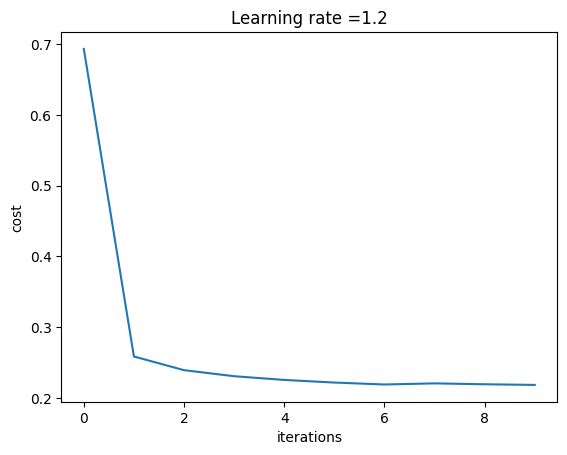

In [15]:
# Build a model with a n_h-dimensional hidden layer
learning_rate = 1.2
parameters, cost_history = nn_model(X, Y, n_h = 4, num_iterations = 10000, learning_rate=learning_rate, print_cost=True)
# Cost
plt.plot(np.squeeze(cost_history))
plt.ylabel('cost')
plt.xlabel('iterations')
plt.title("Learning rate =" + str(learning_rate))
plt.show()

Text(0.5, 1.0, 'Decision Boundary for hidden layer size 4')

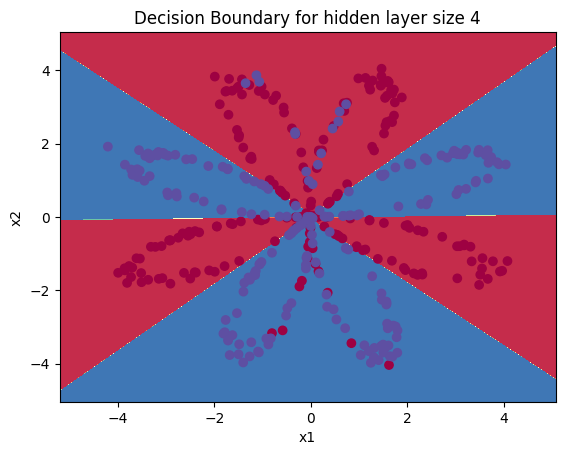

In [16]:
# Plot the decision boundary
plot_decision_boundary(lambda x: predict(parameters, x.T), X, Y)
plt.title("Decision Boundary for hidden layer size " + str(4))

Accuracy for 1 hidden units: 0.675 %
Accuracy for 2 hidden units: 0.6725 %
Accuracy for 3 hidden units: 0.9075 %
Accuracy for 4 hidden units: 0.905 %
Accuracy for 5 hidden units: 0.9125 %


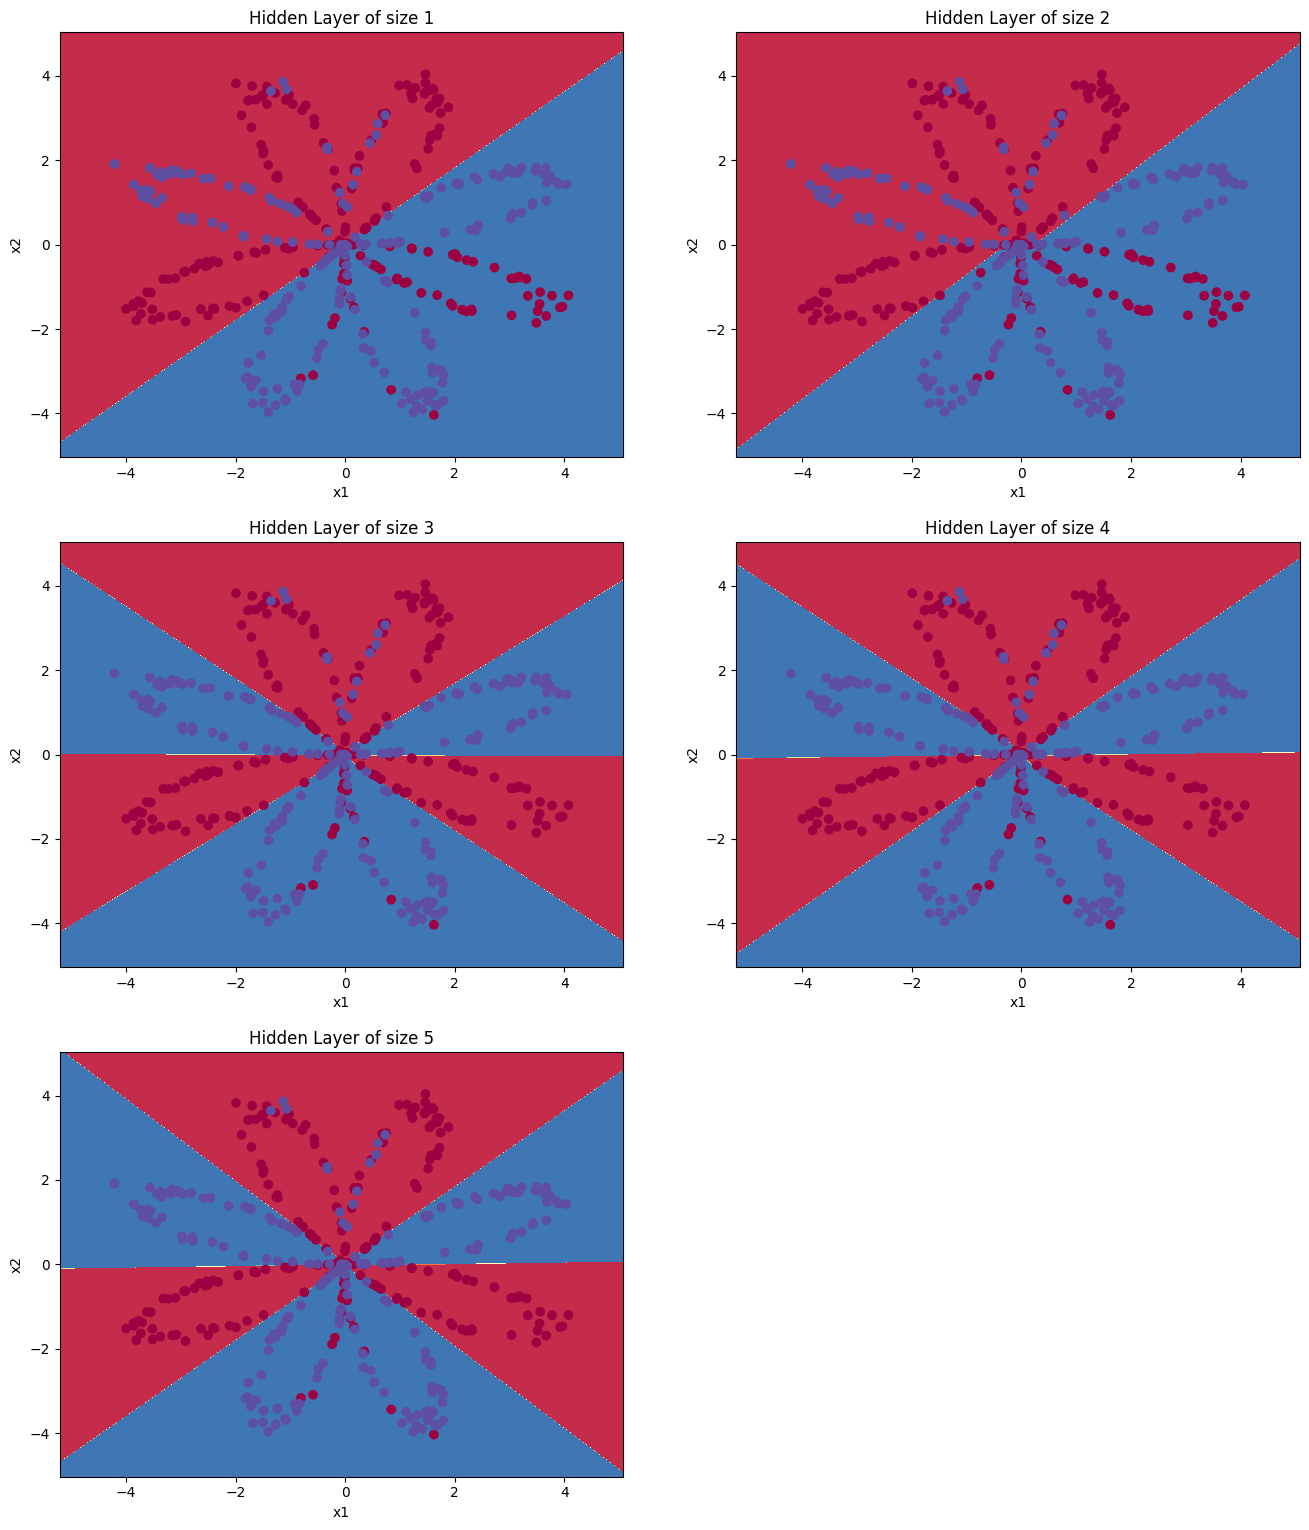

In [17]:
plt.figure(figsize=(16, 32))
hidden_layer_sizes = [1, 2, 3, 4, 5]

for i, n_h in enumerate(hidden_layer_sizes):
    plt.subplot(5, 2, i+1)
    plt.title('Hidden Layer of size %d' % n_h)
    parameters, cost_history = nn_model(X, Y, n_h, num_iterations = 5000, learning_rate=1.2)
    plot_decision_boundary(lambda x: predict(parameters, x.T), X, Y)
    predictions = predict(parameters, X)
    accuracy = accuracy_score(Y.flatten(), predictions.flatten())
    print ("Accuracy for {} hidden units: {} %".format(n_h, accuracy))

## Performance on other datasets

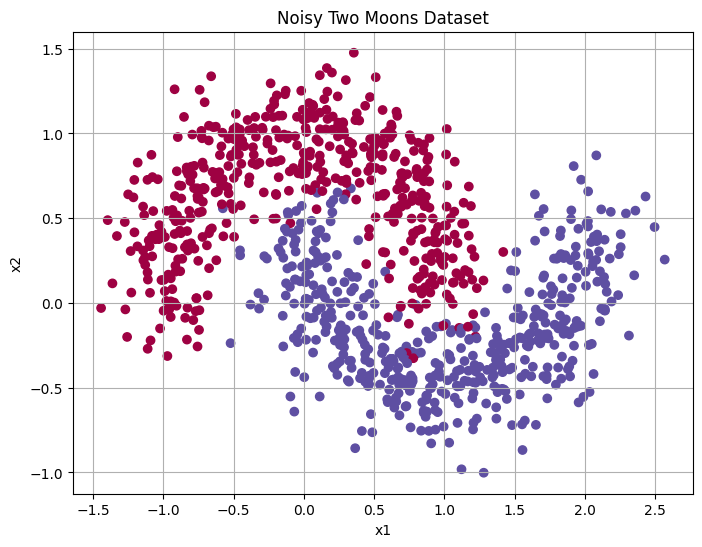

In [19]:
from sklearn.datasets import make_moons

X, Y = make_moons(n_samples=1000, noise=0.2, random_state=42)

# Plot
plt.figure(figsize=(8, 6))
plt.scatter(X[:, 0], X[:, 1], c=Y, cmap=plt.cm.Spectral)
plt.title("Noisy Two Moons Dataset")
plt.xlabel("x1")
plt.ylabel("x2")
plt.grid(True)
plt.show()

Cost after iteration 0: 0.693158
Cost after iteration 1000: 0.290704
Cost after iteration 2000: 0.098034
Cost after iteration 3000: 0.070033
Cost after iteration 4000: 0.067401
Cost after iteration 5000: 0.066098
Cost after iteration 6000: 0.068375
Cost after iteration 7000: 0.065206
Cost after iteration 8000: 0.063737
Cost after iteration 9000: 0.062956


Text(0.5, 1.0, 'Decision Boundary for hidden layer size 4')

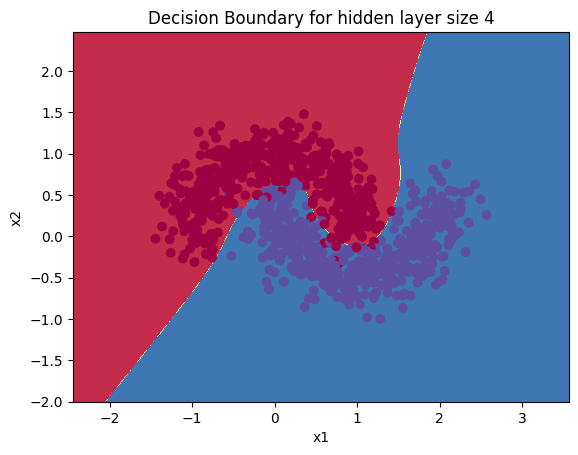

In [20]:
X = X.T
Y = Y.reshape(1, Y.shape[0])
parameters, cost_history = nn_model(X, Y, n_h = 4, num_iterations = 10000, learning_rate=1.2, print_cost=True)
plot_decision_boundary(lambda x: predict(parameters, x.T), X, Y)
plt.title("Decision Boundary for hidden layer size " + str(4))